In [1]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects


2023-05-31 00:03:23.541142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jcampos/miniforge3/lib/:/home/jcampos/miniforge3/lib/
2023-05-31 00:03:23.541167: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import sys 
sys.path.append("..")

import hls4ml
import numpy as np
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt


In [3]:
from utils.config import print_dict

In [4]:
X_train_val = np.load('../data/all/X_train_val.npy')
X_test = np.ascontiguousarray(np.load('../data/all/X_test.npy'))
y_train_val = np.load('../data/all/y_train_val.npy')
y_test = np.load('../data/all/y_test.npy', allow_pickle=True)

In [5]:
co = {} 
_add_supported_quantized_objects(co)
model = load_model('model_1_b16_i6_ex2_v3.h5', custom_objects=co, compile=False)

print(model.summary()) 

2023-05-31 00:03:26.002970: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jcampos/miniforge3/lib/:/home/jcampos/miniforge3/lib/
2023-05-31 00:03:26.003033: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-31 00:03:26.003090: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator3.fnal.gov): /proc/driver/nvidia/version does not exist
2023-05-31 00:03:26.003677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (QDense)             (None, 160)               25760     
                                                                 
 relu1 (QActivation)         (None, 160)               0         
                                                                 
 batchnorm1 (BatchNormalizat  (None, 160)              640       
 ion)                                                            
                                                                 
 layer2 (QDense)             (None, 25)                4025      
                                                                 
 relu2 (QActivation)         (None, 25)                0         
                                                                 
 batchnorm2 (BatchNormalizat  (None, 25)               100       
 ion)                                                   

In [6]:
HLSConfig = {}
HLSConfig['Model'] = {}
HLSConfig['Model']['Precision'] = 'ap_fixed<16,9>'
HLSConfig['Model']['ReuseFactor'] = 1

HLSConfig['LayerName'] = {}
for layer in ['layer1_input', 'layer1', 'relu1', 'relu2', 'layer2', 'layer3', 'layer1_linear', 'layer2_linear', 'layer3_linear', 'batchnorm1', 'batchnorm2']:
    HLSConfig['LayerName'][layer] = {}
    HLSConfig['LayerName'][layer]['Precision'] = {}
    HLSConfig['LayerName'][layer]['Trace'] = True

HLSConfig['LayerName']['layer1_input']['Precision'] = 'ap_fixed<12,12>'

### LAYER 1 ###
HLSConfig['LayerName']['layer1']['Precision']['result'] = 'ap_fixed<16,10>'
HLSConfig['LayerName']['layer1']['accum_t'] = 'ap_fixed<16,10>'
HLSConfig['LayerName']['layer1_linear']['Precision']['result'] = 'ap_fixed<16,10>'

### LAYER 2 ###
HLSConfig['LayerName']['layer2']['Precision']['result'] = 'ap_fixed<16,6>'
HLSConfig['LayerName']['layer2']['accum_t'] = 'ap_fixed<16,6>'
HLSConfig['LayerName']['layer2_linear']['Precision']['result'] = 'ap_fixed<16,6>'

### LAYER 3 ###
HLSConfig['LayerName']['layer3']['Precision']['result'] = 'ap_fixed<16,6>'
HLSConfig['LayerName']['layer3']['accum_t'] = 'ap_fixed<16,6>'
HLSConfig['LayerName']['layer3_linear']['Precision']['result'] = 'ap_fixed<16,6>'

### BATCHNORM 1 ###
HLSConfig['LayerName']['batchnorm1']['Precision']['scale'] = 'ap_fixed<16,3>'
HLSConfig['LayerName']['batchnorm1']['Precision']['bias'] = 'ap_fixed<16,3>'
HLSConfig['LayerName']['batchnorm1']['Precision']['result'] = 'ap_fixed<16,4>'

### BATCHNORM 2 ###
HLSConfig['LayerName']['batchnorm2']['Precision']['result'] = 'ap_fixed<16,6>'

### ACTIVATIONS ###
HLSConfig['LayerName']['relu1']['Precision']['result'] = 'ap_ufixed<16,6,AP_RND,AP_SAT>'
HLSConfig['LayerName']['relu2']['Precision']['result'] = 'ap_ufixed<16,6,AP_RND,AP_SAT>'

print_dict(HLSConfig)

Model
  Precision:         ap_fixed<16,9>
  ReuseFactor:       1
LayerName
  layer1_input
    Precision:       ap_fixed<12,12>
    Trace:           True
  layer1
    Precision
      result:        ap_fixed<16,10>
    Trace:           True
    accum_t:         ap_fixed<16,10>
  relu1
    Precision
      result:        ap_ufixed<16,6,AP_RND,AP_SAT>
    Trace:           True
  relu2
    Precision
      result:        ap_ufixed<16,6,AP_RND,AP_SAT>
    Trace:           True
  layer2
    Precision
      result:        ap_fixed<16,6>
    Trace:           True
    accum_t:         ap_fixed<16,6>
  layer3
    Precision
      result:        ap_fixed<16,6>
    Trace:           True
    accum_t:         ap_fixed<16,6>
  layer1_linear
    Precision
      result:        ap_fixed<16,10>
    Trace:           True
  layer2_linear
    Precision
      result:        ap_fixed<16,6>
    Trace:           True
  layer3_linear
    Precision
      result:        ap_fixed<16,6>
    Trace:           True
  batch

In [7]:
OutputDir = 'model1/'
XilinxPart = 'xczu49dr-ffvf1760-2-e'
IOType = 'io_parallel'
ClockPeriod = 5
HLSFig = OutputDir+'model.png'
HLSConfig['Model']['strategy'] = 'resource'

hls_model = hls4ml.converters.convert_from_keras_model(
    model=model,
    hls_config=HLSConfig,
    output_dir=OutputDir,
    part=XilinxPart,
    io_type=IOType,
    clock_period=ClockPeriod,
    backend='VivadoAccelerator',
    # interface='axi_master',
    # driver='c',
    # board='zcu216',
)


Interpreting Sequential
Topology:
Layer name: layer1_input, layer type: InputLayer, input shapes: [[None, 160]], output shape: [None, 160]
Layer name: layer1, layer type: QDense, input shapes: [[None, 160]], output shape: [None, 160]
Layer name: relu1, layer type: Activation, input shapes: [[None, 160]], output shape: [None, 160]
Layer name: batchnorm1, layer type: BatchNormalization, input shapes: [[None, 160]], output shape: [None, 160]
Layer name: layer2, layer type: QDense, input shapes: [[None, 160]], output shape: [None, 25]
Layer name: relu2, layer type: Activation, input shapes: [[None, 25]], output shape: [None, 25]
Layer name: batchnorm2, layer type: BatchNormalization, input shapes: [[None, 25]], output shape: [None, 25]
Layer name: layer3, layer type: QDense, input shapes: [[None, 25]], output shape: [None, 3]
Creating HLS model


In [8]:
print(f"Creating hls4ml project directory {OutputDir}")
hls_model.compile()

# Visualize model
hls4ml.utils.plot_model(
    hls_model, show_shapes=True, show_precision=True, to_file=HLSFig
)

Creating hls4ml project directory model1/
Writing HLS project


Done


In [9]:
# Run predict on hls and keras models and save to .dat files
X_test = np.ascontiguousarray(X_test)

# Save inputs   
np.savetxt('inputs.dat', X_test, fmt='%i')  # (1000, 800)

for slice_index in range(5):
    t = slice_index+1
    X_test_slice = X_test[:,160*(t-1):160*t]  # (1000, 160)

    # Get predictions from hls and keras model 
    y_hls_slice = hls_model.predict(np.ascontiguousarray(X_test_slice))
    y_keras_slice = model.predict(X_test_slice)
    
    # Save predictions (output precision ap_fixed<16,6>)
    np.savetxt(f'y_hls_slice{slice_index+1}.dat', y_hls_slice, fmt='%.10f')
    np.savetxt(f'y_keras_slice{slice_index+1}.dat', y_keras_slice, fmt='%.10f')
    
    # Accuracy for each slice, (y_true, y_pred) = (keras_predictions, hls_predictions)
    slice_acc = accuracy_score(np.argmax(y_keras_slice, axis=1), np.argmax(y_hls_slice, axis=1))
    print(f'Slice {slice_index+1} Accuracy: {slice_acc}')


32/32 [==============================] - 0s 3ms/step
Slice 1 Accuracy: 0.964
32/32 [==============================] - 0s 2ms/step
Slice 2 Accuracy: 0.981
32/32 [==============================] - 0s 2ms/step
Slice 3 Accuracy: 0.97
32/32 [==============================] - 0s 2ms/step
Slice 4 Accuracy: 0.965
32/32 [==============================] - 0s 1ms/step
Slice 5 Accuracy: 0.98


In [10]:
# Save input as separate time slice
for t in range(1, 6):
    np.savetxt(f'model1_tb/x_test_slice{t}.dat', X_test[:,160*(t-1):160*t], fmt='%i')  # (1000, 160)

In [11]:
# Trace first time slice for correlation plots 
t = 1

y_hls = hls_model.predict(np.ascontiguousarray(X_test[:,160*(t-1):160*t])) 
_, hls_trace = hls_model.trace(np.ascontiguousarray(X_test[:,160*(t-1):160*t])) 

keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test[:,160*(t-1):160*t]) 

Recompiling myproject with tracing
Writing HLS project


Done
Processing layer1 in Keras model...
32/32 [==============================] - 0s 901us/step
Processing relu1 in Keras model...
32/32 [==============================] - 0s 1ms/step
Processing batchnorm1 in Keras model...
32/32 [==============================] - 0s 1ms/step
Processing layer2 in Keras model...
32/32 [==============================] - 0s 2ms/step
Processing relu2 in Keras model...
32/32 [==============================] - 0s 1ms/step
Processing batchnorm2 in Keras model...
32/32 [==============================] - 0s 2ms/step
Processing layer3 in Keras model...
32/32 [==============================] - 0s 2ms/step
Done taking outputs for Keras model.


layer1 		 0.24803218
hls/keras min: -337.328125/-336.421875
hls/keras max: 367.015625/367.94140625


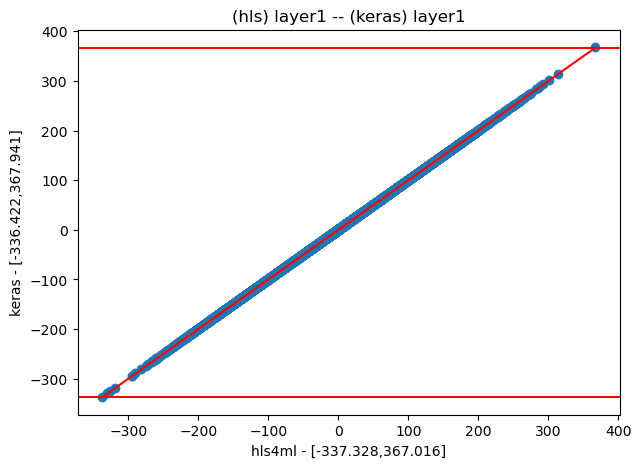

relu1 		 0.083414584
hls/keras min: 0.0/0.0
hls/keras max: 63.9990234375/63.9990234375


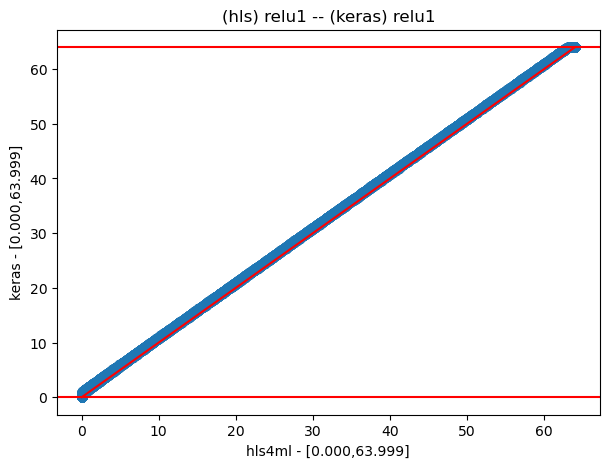

batchnorm1 		 0.006822284
hls/keras min: -1.8271484375/-1.8270792961120605
hls/keras max: 4.36279296875/4.363320827484131


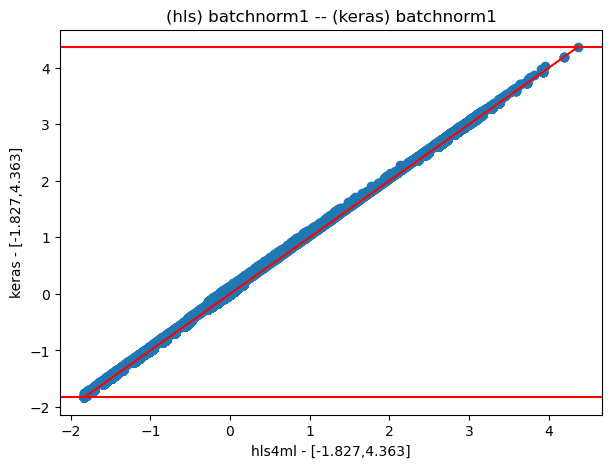

layer2 		 0.01104994
hls/keras min: -1.76171875/-1.7486116886138916
hls/keras max: 1.3974609375/1.4163872003555298


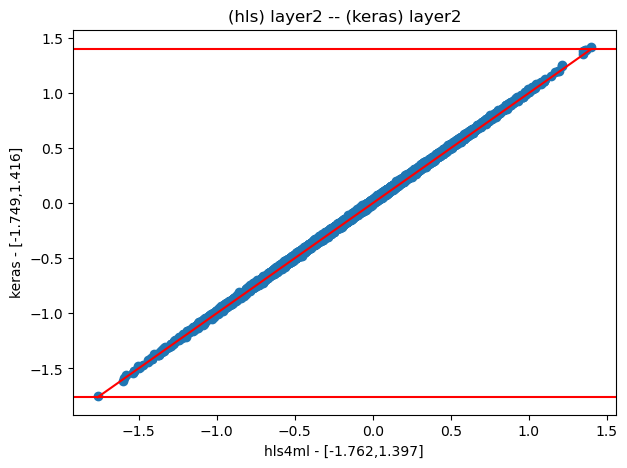

relu2 		 0.004051953
hls/keras min: 0.0/0.0
hls/keras max: 1.3974609375/1.416015625


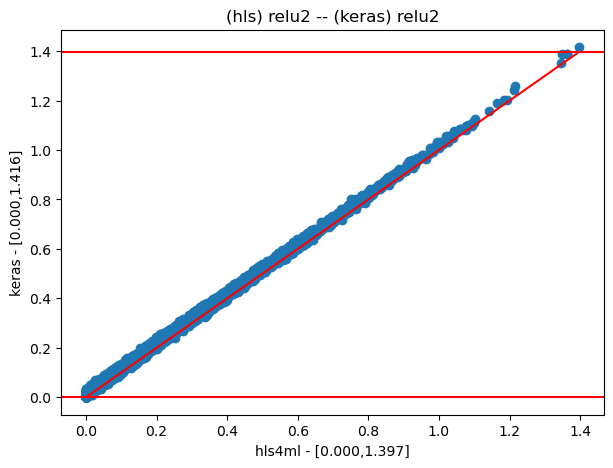

batchnorm2 		 0.034638926
hls/keras min: -1.3203125/-1.3161078691482544
hls/keras max: 9.7119140625/9.875337600708008


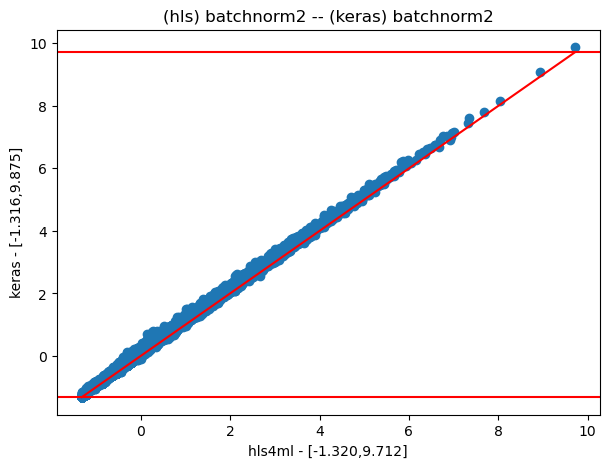

layer3 		 0.035800584
hls/keras min: -2.470703125/-2.5854790210723877
hls/keras max: 2.650390625/2.77091121673584


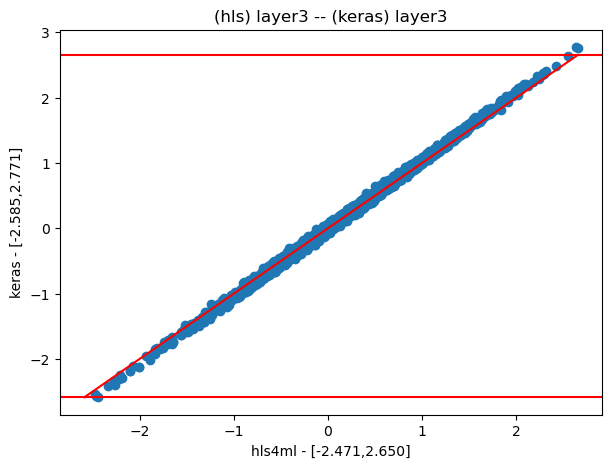

In [12]:
layers = ['layer1', 'relu1', 'batchnorm1', 'layer2', 'relu2', 'batchnorm2', 'layer3']

for idx, layer in enumerate(layers):
    keras_layer, hls_layer = keras_trace[layer], hls_trace[layer]
    try:
        diff = np.average(np.abs(keras_layer - hls_layer ))
        print(f'{layer}', '\t\t', diff)
        
        plt.figure(figsize=(7, 5))

        plt.scatter(hls_layer.flatten(), keras_layer.flatten())
        min_x = min(keras_layer.min(), hls_layer.min())
        max_x = min(keras_layer.max(), hls_layer.max())

        onnx_min, onnx_max = keras_layer.flatten().min(), keras_layer.flatten().max()
        hls_min, hls_max = hls_layer.flatten().min(), hls_layer.flatten().max()
        
        print(f'hls/keras min: {hls_min}/{onnx_min}')
        print(f'hls/keras max: {hls_max}/{onnx_max}')
        
        plt.plot([min_x, max_x], [min_x, max_x], c='red')
        plt.axhline(min_x, c='red')
        plt.axhline(max_x, c='red')
        # plt.plot([min_x, max_x], [min_x, max_x], c='red')

        plt.title(f'(hls) {layer} -- (keras) {layer}')
        plt.xlabel(f'hls4ml - [{hls_min:.3f},{hls_max:.3f}]')
        plt.ylabel(f'keras - [{onnx_min:.3f},{onnx_max:.3f}]')
        plt.show()
        
        plt.savefig(f'../results/{idx}_(hls){layer} -- (keras){layer}.png')
        plt.close()

    except Exception as e:
        print(e)
